# 데이터 증강

- 훈련 성능을 향상시키는 방법은 훈련용 이미지를 더 많이 생성하는 것이다!

- Data Augmentation을 지원하는 케라스의 ImageDataGenerator를 알아보자

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, regularizers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
 
EPOCHS=50
NUM_CLASSES = 10
    

def load_data():
    (x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
 
    #normalize 
    mean = np.mean(x_train,axis=(0,1,2,3))
    std = np.std(x_train,axis=(0,1,2,3))
    x_train = (x_train-mean)/(std+1e-7)
    x_test = (x_test-mean)/(std+1e-7)
 
    y_train =  tf.keras.utils.to_categorical(y_train,NUM_CLASSES)
    y_test =  tf.keras.utils.to_categorical(y_test,NUM_CLASSES)

    return x_train, y_train, x_test, y_test

def build_model(): 
    model = models.Sequential()
    
    #1st blocl
    model.add(layers.Conv2D(32, (3,3), padding='same', 
        input_shape=x_train.shape[1:], activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.2))

    #2nd block
    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.3))

    #3d block 
    model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.4))

    #dense  
    model.add(layers.Flatten())
    model.add(layers.Dense(NUM_CLASSES, activation='softmax'))
    return model

    model.summary()

In [ ]:
(x_train, y_train, x_test, y_test) = load_data()
model = build_model()
model.compile(loss='categorical_crossentropy', 
            optimizer='RMSprop', 
            metrics=['accuracy'])

170508288/170498071 [==============================] - 2s 0us/step


In [ ]:
#image augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    )
datagen.fit(x_train)

In [ ]:
datagen

In [ ]:
batch_size = 64

# flow 메소드로 X, y 이미지를 한 번에 몇 개 업로드 시킬지에 대해 배치 사이즈 설정, 데이터 섞을 유무를 지정
flow_tr_gen = datagen.flow(x_train, y_train, batch_size=batch_size, shuffle = True)

In [ ]:
image_batch, label_batch = next(flow_tr_gen)
print(image_batch.shape, label_batch.shape)

(64, 32, 32, 3) (64, 10)


In [ ]:
print(image_batch[1].shape)

(32, 32, 3)


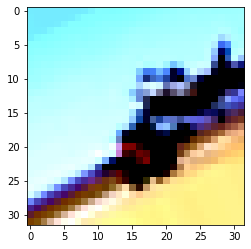

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(image_batch[1])

In [ ]:
len(x_train)

50000

In [ ]:
# 살짝 증가한 것을 확인할 수 있다.
len(flow_tr_gen) * 64

50048

# 증강 후에 학습 종류 3가지

# fit vs fit_generator vs train_on_batch

- fit : 데이터 x, y 전체를 한 번에 모델 입력으로 사용한다, 그만큼 메모리를 많이 사용하므로 적은 양의 데이터에 사용한다.
   + ex) mnist는 28x28x1
<br><br>
- fit_generator : 대용량의 데이터를 효율적으로 학습하기 위한 것으로 모델에 generator를 통해 형성된 데이터를 batch size로 입력에 넣어 학습하는 방법

   -> CPU를 parallel하게 사용할 때 효율적<br>
   -> ex) cifar10은 32x32x3으로 mnist보다 데이터 복잡도가 크다
<br><br>
- train_on_batch : train_on_batch를 사용하기 좋은 케이스는 pre-trained 모델을 단일 배치로 학습시켜야 할 때이다.

<br><br>
- 공통점 : 셋 다 history, loss, accuracy를 반환한다.

```
훈련하는 것을 보면 flow_tr_gen의 batch 단위로 학습이 일어난다.
```

In [ ]:
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size, shuffle = True),
                    epochs=1, 
                    verbose=1,validation_data=(x_test,y_test))


#save to disk
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)
model.save_weights('model.h5') 

#test
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0])) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


79/79 [==============================] - 12s 154ms/step - loss: 1.6127 - accuracy: 0.5125

Test result: 51.250 loss: 1.613


# 이미지 전처리 

-> cnn 학습에 필수적인 단계(아래 실습 내용이 있다.)
<br><br><br>
1.실수화 : 이미지를 원본 그대로 넣으면 시각화할 수 없었다.

2.ndarray화 : 이미지를 효율적으로 처리하기 위해서 넘파이로 형변환한다.

-> cv2로 이미지를 로드하면 실수화를 안해도 시각화할 수 있다.(실수화와 ndarray 형변환을 처리한 결과를 출력한다.)

TypeError: ignored

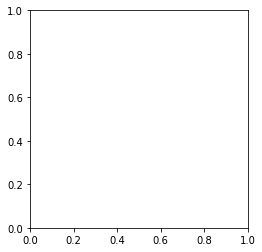

In [ ]:
# 실수화를 하지 않은 경우 시각화할 수 없음
plt.imshow("/content/cat-standing.jpg")

In [ ]:
# 실수화 밑 ndarray 형식 변환
imgs = resize(imread("/content/cat-standing.jpg"), (32, 32)).astype("float32")
imgs = np.array(imgs) / 255

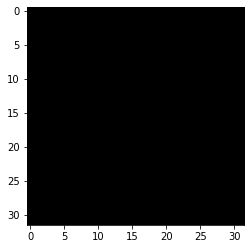

In [ ]:
plt.imshow(imgs)

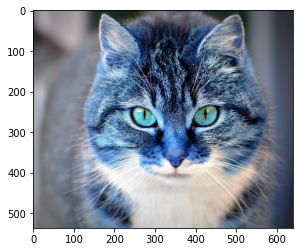

In [ ]:
# cv2로 이미지 로드
import cv2
image = cv2.imread("/content/cat-standing.jpg")
plt.imshow(image)

In [ ]:
# 이미지 전처리(자료형 변경)
from tensorflow.keras.preprocessing.image import img_to_array
IMG_CHANNELS = 3
IMG_ROWS = 32
IMG_COLS = 32

image = cv2.resize(image, dsize = (IMG_ROWS, IMG_COLS))

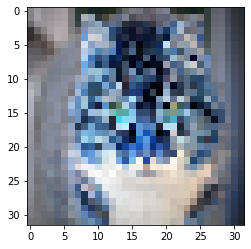

In [ ]:
plt.imshow(image)

In [ ]:
image = image.reshape(1,image.shape[0],image.shape[1], image.shape[2]) # 학습 시에 배치로 학습을 하기 위한 작업이다
image.shape

(1, 32, 32, 3)

In [ ]:
predictions = model.predict(image, verbose=0) 
predictions = predictions.argmax(axis=-1)
print("predictions:", predictions)

predictions: [0]


In [ ]:
import numpy as np
#import scipy.misc

from skimage.transform import resize
from imageio import imread

from tensorflow.keras.models import model_from_json
from tensorflow.keras.optimizers import SGD

model_architecture = "/content/model.json"
model_weights = "/content/model.h5"
model = model_from_json(open(model_architecture).read())
model.load_weights(model_weights)

img_names = ["/content/images.jpg", "/content/다운로드.jpg"]
img_names = ["cat-standing.jpg", "dog.jpg"]

# (32 x 32)로 reshape하고 transpose를 통해 배치 차원 추가
# imgs = [np.transpose(resize(imread(img_name), (32, 32)), (2, 0, 1)).astype("float32") for img_name in img_names]

# (32 x 32)로 reshape하고 실수화 및 ndarray 형식으로 변환
imgs = [resize(imread(img_name), (32, 32)).astype("float32") for img_name in img_names]
imgs = np.array(imgs) / 255
print("imgs.shape:", imgs.shape)

optim = SGD()

model.compile(loss="categorical_crossentropy", optimizer=optim, metrics=["accuracy"])

# 오류 -> predict_classes를 처리할 수 없다.
# predictions = model.predict_classes(imgs)
# print("predictions:", predictions)

# 오류 해결 -> argmax로 클래스 분류와 같은 효과
predictions = model.predict(imgs, verbose=0) 
predictions = predictions.argmax(axis=-1)
print("predictions:", predictions)


imgs.shape: (2, 32, 32, 3)
predictions: [0 0]


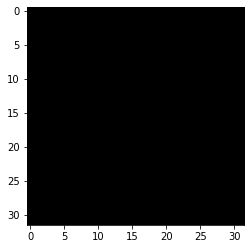

In [ ]:
plt.imshow(imgs[1])

```
fit보다 fit_gene가 더 속도가 20ms정도 빠르다!!! -> 데이터의 크기가 크고 모델의 깊이가 깊어지면 이 크기는 더 커질 것이다.
```

In [ ]:
model.fit(datagen.flow(x_train, y_train, batch_size=batch_size, shuffle = True),
                    epochs=1, 
                    verbose=1,validation_data=(x_test,y_test))

782/782 [==============================] - 327s 417ms/step - loss: 1.5125 - accuracy: 0.5043 - val_loss: 1.3874 - val_accuracy: 0.5726


# 전이학습

## 원본코드 분석

-> 분석 결과 : 모델 가중치를 로드할 때는 모델의 구조가 있어야 하고 저장한 path와 동일한 file_path에서 가중치 로드를 해야한다.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2, numpy as np
import os

# define a VGG16 network
def VGG_16(weights_path=None):
    model = models.Sequential()
    model.add(layers.ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(layers.Convolution2D(64, (3, 3), activation='relu'))
    model.add(layers.ZeroPadding2D((1,1)))
    model.add(layers.Convolution2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2), strides=(2,2)))

    model.add(layers.ZeroPadding2D((1,1)))
    model.add(layers.Convolution2D(128, (3, 3), activation='relu'))
    model.add(layers.ZeroPadding2D((1,1)))
    model.add(layers.Convolution2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2), strides=(2,2)))

    model.add(layers.ZeroPadding2D((1,1)))
    model.add(layers.Convolution2D(256, (3, 3), activation='relu'))
    model.add(layers.ZeroPadding2D((1,1)))
    model.add(layers.Convolution2D(256, (3, 3), activation='relu'))
    model.add(layers.ZeroPadding2D((1,1)))
    model.add(layers.Convolution2D(256, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2), strides=(2,2)))

    model.add(layers.ZeroPadding2D((1,1)))
    model.add(layers.Convolution2D(512, (3, 3), activation='relu'))
    model.add(layers.ZeroPadding2D((1,1)))
    model.add(layers.Convolution2D(512, (3, 3), activation='relu'))
    model.add(layers.ZeroPadding2D((1,1)))
    model.add(layers.Convolution2D(512, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2), strides=(2,2)))

    model.add(layers.ZeroPadding2D((1,1)))
    model.add(layers.Convolution2D(512, (3, 3), activation='relu'))
    model.add(layers.ZeroPadding2D((1,1)))
    model.add(layers.Convolution2D(512, (3, 3), activation='relu'))
    model.add(layers.ZeroPadding2D((1,1)))
    model.add(layers.Convolution2D(512, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2), strides=(2,2)))

    model.add(layers.Flatten())

    #top layer of the VGG net
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1000, activation='softmax'))

    if weights_path:
        model.load_weights(weights_path)

    return model


im = cv2.resize(cv2.imread('cat.jpg'), (224, 224)).astype(np.float32)
#im = im.transpose((2,0,1))
im = np.expand_dims(im, axis=0)

# Test pretrained model
# path_file = os.path.join(os.path.expanduser("~"), '.keras/models/vgg16_weights_tf_dim_ordering_tf_kernels.h5')
path_file = "how_to_download_vgg16_weights.h5"
model = VGG_16(path_file)
model.summary()
model.compile(optimizer='sgd', loss='categorical_crossentropy')
out = model.predict(im)
print(np.argmax(out))
  

OSError: ignored

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2, numpy as np
import os

im = cv2.resize(cv2.imread('cat.jpg'), (224, 224)).astype(np.float32)
#im = im.transpose((2,0,1))
im.shape

(224, 224, 3)

In [ ]:
im = np.expand_dims(im, axis=0)
im.shape

(1, 224, 224, 3)

In [ ]:
path_file = os.path.join(os.path.expanduser("~"), '/content/how_to_download_vgg16_weights.h5')

In [ ]:
print(path_file)

/content/how_to_download_vgg16_weights.h5


# 모델 저장 심화

-> 저장 방법 분석

참고 : https://ysyblog.tistory.com/153

```
궁금증 : 

file path로 저장을 하면 ↓의 사진처럼 생긴다.

-> 그러면 로드할 때는 checkpoint 파일로 해야하는 거 아닌가?
왜 file_path로 하지?

```

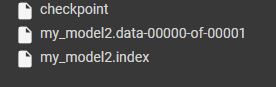

In [ ]:
file_path = "my_model2"

# os.mkdir(file_path)
model.save_weights(file_path) # 가중치 저장
model.load_weights(file_path) # 모델 상태 복원

## 위 블로그에서 해답을 알아보자

-> index와 .data에 체크포인트를 매칭하는 checksum이 있다. 따라서 file path로 접근하면 checkpoint를 쓸 수 있다.

```
1. 학습이 끝난 모델의 파라미터만 저장 = 가중치를 저장하여 나중에 재학습 없이 학습된 가중치를 사용할 수 있다.

- 저장형식
1. Checkpoint(기본 방식0
2. HDF5 : save_weights(   , save_format = 'h5')
```

In [ ]:
import os
cur_dir = os.getcwd() # 현재 작업 디렉
ckpt_dir = "checkpoints" # weight를 저장할 디렉토리
file_name = "mnist_cnn_weights.ckpt" # 저장 파일명

#현재 작업 dir와 w를 저장할 dir을 join함
# ,로 구분된 두개를 합쳐서 문자열로 반환
dir = os.path.join(cur_dir, ckpt_dir) 
os.makedirs(dir, exist_ok = True) # dir이라는 폴더를 만듬

file_path = os.path.join(dir, file_name) #dir 경로 + 파일 이름의 파일 경로를 join함
print(file_path)

/content/checkpoints/mnist_cnn_weights.ckpt


## 훈련된 모델 만들기를 위한 모델 훈련하기

In [ ]:
# ① modelcheckpoint 예제


import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical


# network and training
EPOCHS = 10
BATCH_SIZE = 128
VERBOSE = 1
NB_CLASSES = 10   # number of outputs = number of digits
N_HIDDEN = 128 
VALIDATION_SPLIT=0.2

mnist = keras.datasets.mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

RESHAPE = 784

X_train = X_train.reshape(60000, RESHAPE)
X_test = X_test.reshape(10000, RESHAPE)
 
X_train = X_train.astype('float32') # 32비트 정밀도를 갖도록 float32로 변환, 0 ~ 1사이로 정규화 -> 이렇게 하면 소수점 20자리가 4자리로 안정화된다
X_test = X_test.astype('float32')

# normalize in [0, 1]
X_train /= 255
X_test /= 255


Y_train = tf.keras.utils.to_categorical(Y_train, NB_CLASSES)
Y_test = tf.keras.utils.to_categorical(Y_test, NB_CLASSES)


#build the model

DROPOUT = 0.3

model = tf.keras.models.Sequential()
model.add(keras.layers.Dense(N_HIDDEN,
   		input_shape=(RESHAPE,),
   		name='dense_layer', activation='relu'))
model.add(keras.layers.Dropout(DROPOUT))
model.add(keras.layers.Dense(N_HIDDEN,
   		name='dense_layer_2', activation='relu'))
model.add(keras.layers.Dropout(DROPOUT))
model.add(keras.layers.Dense(NB_CLASSES,
   		name='dense_layer_3', activation='softmax'))

model.summary()

# compiling the model
model.compile(optimizer='SGD', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#training the model
model.fit(X_train, Y_train,
		batch_size=BATCH_SIZE, epochs=EPOCHS,
		verbose=VERBOSE, validation_split=VALIDATION_SPLIT) 

#evaluate the model
test_loss, test_acc = model.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc)

# making prediction
predictions = model.predict(X_test)


11501568/11490434 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_layer (Dense)         (None, 128)               100480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_layer_2 (Dense)       (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_layer_3 (Dense)       (None, 10)                1290      
                                                                 
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
___________________________________________________

## 모델 파라미터 저장

In [ ]:
# 저장은 file path로 하고 위 사진과 같은 파일들이 생성됨
model.save_weights(file_path)

## 모델 파라미터 불러오기

-> 이를 위해서 모델 구조 또한 같이 저장하고 그대로 넣어줘야한다!

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file : 
    json_file.write(model_json)

In [ ]:
from keras.models import model_from_json 

json_file = open("model.json", "r")
loaded_model_json = json_file.read() 
json_file.close()

loaded_model = model_from_json(loaded_model_json)

In [ ]:
# 결론적으로 똑같은 file_path를 인자로 넣는게 맞다.
loaded_model.load_weights(file_path)

In [ ]:
# 이건 걍 무조건 해야함
loaded_model.compile(optimizer='SGD', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
test_loss, test_acc = loaded_model.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc)

313/313 [==============================] - 1s 2ms/step - loss: 0.2578 - accuracy: 0.9254
Test accuracy: 0.9254000186920166


### vgg 라이브러리 사용

-> 285가 브라질 고양이다.

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
import numpy as np
import cv2

# include_top을 하면 vgg 분류기까지 가져온다는 얘기
model = VGG16(weights='imagenet', include_top=True) 
model.compile(optimizer='sgd', loss='categorical_crossentropy')

# resize into VGG16 trained images' format
im = cv2.resize(cv2.imread('/content/cat.jpg'), (224, 224))
im = np.expand_dims(im, axis=0) # 1, 224, 224, 3이 된다.
im.astype(np.float32)

# predict
out = model.predict(im)
index = np.argmax(out)
print(index)

#plt.plot(out.ravel())
#plt.show()

285


### 전이학습에 분류기만 추가로 쌓는 방법

In [ ]:
base_model = VGG16(input_shape=(32, 32, 3), include_top=False, weights='imagenet') # 특징 추출 layer의 w들은 유지

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
bm_output = base_model.output

In [ ]:
output_layer = GlobalAveragePooling2D()(bm_output)
output_layer = Dense(50, activation='relu')(output_layer)
output_layer = Dense(10, activation='softmax')(output_layer)

In [ ]:
output_layer = Dense(10, activation='softmax')(output_layer)
model = Model(inputs=base_model.input, outputs=output_layer)

In [ ]:
model.compile(optimizer=Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
batch_size = 64
epochs = 10

# 이러면 분류기만 내 이미지로 다시 훈련 하는 것이다 -> 내 이미지와 사전학습 이미지(이미지넷)가 비슷하면 layer를 적게 쌓고, 안 비슷하면 많이 쌓아야한다.
history = model.fit(x=train_x, y=train_y, batch_size=batch_size, epochs=epochs, validation_data=(val_x, val_y)) 

# 사전 구축된 모델에서 특징만 추출

원래는 모델은 분류기를 때고 가져와서 추가로 layer를 쌓고 재학습하는 것이 전이학습의 기본이다.
<br> -> 여기서는 분류기를 버리고 추가로 쌓는 것이 아니라 output을 중간 계층으로 잡는다.

<br><br>


이것은 같은 얘기라고 생각할 수 있는데 중간 계층에서 바로 predict를 한다.
이는 중간 계층은 이미지에서 중요한 특징을 추출하는 능력을 가지며, 이러한 특징은 다른 종류의 분류에 도움이 될 가능성이 더 높으므로 중간계층의 일반화된 예측 능력을 사용하자는 의도이다.

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16 
from tensorflow.keras import models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
import cv2

# prebuild model with pre-trained weights on imagenet
base_model = VGG16(weights='imagenet', include_top=True)
print (base_model)
for i, layer in enumerate(base_model.layers):
	print (i, layer.name, layer.output_shape)

# extract features from block4_pool block
model = models.Model(inputs=base_model.input, 
	outputs=base_model.get_layer('block4_pool').output)

img_path = 'cat.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# get the features from this block
features = model.predict(x)
print(features)